<a href="https://colab.research.google.com/github/kristupaspranc/machine_learning/blob/main/ASL_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00


In [2]:
!pip install leven

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for leven: filename=leven-1.0.4-cp310-cp310-linux_x86_64.whl size=64146 sha256=57e77ed5d4481ad26ad42b2cb2816b324e56433f5014f4cebf6dc3ac2687c26f
  Stored in directory: /root/.cache/pip/wheels/a8/c7/c4/99e93cc37bb627f3d4d153d1a62feb3491c2e832a33e3ea2dc
Successfully built leven


In [3]:
from google.colab import files
import subprocess
import pandas as pd
import json
import pandas as pd
import fastparquet #to inspect parquet format file
import os

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf
#import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein
from pathlib import Path

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import re
import json

In [5]:
# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version 2.15.0
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


Matlplotlib

In [6]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

Data Downloading

In [7]:
class DataIntoSystem():

  def __init__(self, sorting_element="train_landmarks"):
    self.kaggle_api_key()
    self.download_meta_data()
    self.download_data(sorting_element)


  def kaggle_api_key(self):
    """
    kaggle_api_key uploads api key to use the api
    """

    files.upload()

    !rm -r ~/.kaggle
    !mkdir ~/.kaggle
    !mv ./kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json


  def files_list_to_download(self,sorting_element="train_landmarks"):
    """
    files_list_to_download returns a list of chosen train data files names

    sorting_element can be either "train_landmarks" or "supplemental_landmarks" depending which data is needed
    """

    if sorting_element != "train_landmarks" and sorting_element != "supplemental_landmarks":
      raise Exception("Argument is either 'supplemental_landmarks' or 'trains_landmarks'")

    try:
      files_info = !kaggle competitions files asl-fingerspelling
    except:
      raise Exception("Cannot read the files info from kaggle competition")

    return [i.split(' ')[0] for i in files_info if sorting_element in i]


  def download_data(self,sorting_element="train_landmarks"):
    """
    download_data removes current data, downloads and unzips the new one chosen by parameter and removes the zip files

    sorting_element can be either "train_landmarks" (by default) or "supplemental_landmarks" depending which data is needed
    """

    !rm /root/ASL_data/train_landmarks/*

    if sorting_element != "train_landmarks" and sorting_element != "supplemental_landmarks":
      raise Exception("Argument is either 'supplemental_landmarks' or 'trains_landmarks'")

    try:
      files_info = !kaggle competitions files asl-fingerspelling
    except:
      Exception("Cannot read the files info from kaggle competition")

    !mkdir /root/ASL_data
    !mkdir /root/ASL_data/train_landmarks

    try:
      for i in [i.split(' ')[0] for i in files_info if sorting_element in i]:
        !kaggle competitions download -c asl-fingerspelling -f {i} -p /root/ASL_data/train_landmarks
        !unzip /root/ASL_data/train_landmarks/{i.split("/")[1]+".zip"} -d /root/ASL_data/train_landmarks
        !rm /root/ASL_data/train_landmarks/{i.split("/")[1]+".zip"}
    except:
      Exception("Failed to download train data")


  def all_downloadable_files(self):
    """
    all_dowloadable_files return a pandas framework of the data given in the competition
    """
    try:
      files_info = !kaggle competitions files asl-fingerspelling
    except:
      raise Exception("Cannot read the files info from kaggle competition")

    return pd.DataFrame(files_info)


  def download_meta_data(self):
    """
    download_meta_data downloads the meta data to ASL_data, unzips it and removes the zip files
    """

    !mkdir /root/ASL_data

    files = ['character_to_prediction_index.json','supplemental_metadata.csv','train.csv']

    for i in files:
      !kaggle competitions download -c asl-fingerspelling -f {i} -p /root/ASL_data

    !unzip /root/ASL_data/supplemental_metadata.csv.zip -d /root/ASL_data
    !unzip /root/ASL_data/train.csv.zip -d /root/ASL_data

    !rm /root/ASL_data/supplemental_metadata.csv.zip
    !rm /root/ASL_data/train.csv.zip

  def show_supplemental_metadata(self):
    """
    show_supplemental_metadata reads the csv file of supplemental_metadata and returns it as pandas dataframe
    """
    try:
      df = pd.read_csv("/root/ASL_data/supplemental_metadata.csv")
    except:
      raise Exception("No such file exists")

    return df


  def show_train_metadata(self):
    """
    show_train_metadata reads the csv file of train metadata and returns it as pandas dataframe
    """
    try:
      df = pd.read_csv("/root/ASL_data/train.csv")
    except:
      raise Exception("No such file exists")

    return df

In [8]:
class DataPreprocessing():

  def __init__(self):
    self.path_of_train_data = '/root/ASL_data/ASL_train_data'

    #get a dictionary of unique characters
    with open('/root/ASL_data/character_to_prediction_index.json') as json_file:
      self.chars = json.load(json_file)

    #number of unique characters
    self.n_of_chars = len(self.chars)

    #list of train data files' names
    self.list_of_parquet_files = os.listdir(self.path_of_train_data)



  def preview_parquet(self, path='/root/ASL_data/ASL_train_data/1019715464.parquet'):
    """
    lets preview data file with given path
    """
    df = pd.read_parquet('/root/ASL_data/ASL_train_data/1019715464.parquet', engine='fastparquet')
    print(df.head())


  def remove_z_coordinates(self):
    pass

In [9]:
data = DataIntoSystem()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/405 [00:00<?, ?B/s]
100% 405/405 [00:00<00:00, 1.29MB/s]
100% 840k/840k [00:00<00:00, 1.25MB/s]
100% 840k/840k [00:00<00:00, 1.25MB/s]
 83% 1.00M/1.20M [00:00<00:00, 1.43MB/s]
100% 1.20M/1.20M [00:00<00:00, 1.65MB/s]
Archive:  /root/ASL_data/supplemental_metadata.csv.zip
  inflating: /root/ASL_data/supplemental_metadata.csv  
Archive:  /root/ASL_data/train.csv.zip
  inflating: /root/ASL_data/train.csv  
rm: cannot remove '/root/ASL_data/train_landmarks/*': No such file or directory
mkdir: cannot create directory ‘/root/ASL_data’: File exists
100% 1.25G/1.26G [00:55<00:00, 22.9MB/s]
100% 1.26G/1.26G [00:55<00:00, 24.2MB/s]
Archive:  /root/ASL_data/ASL_train_data/105143404.parquet.zip
  inflating: /root/ASL_data/ASL_train_data/105143404.parquet  
100% 1.24G/1.24G [00:55<00:00, 30.0MB/s]
100% 1.24G/1.24G [00:55<00:00, 23.8MB/s]
Archive:  /root/ASL_data/ASL_train_data/128822441.parquet.

Ordinal Encoding Mapping

In [10]:
# Read Character to Ordinal Encoding Mapping
with open('/root/ASL_data/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}

# Character to Ordinal Encoding Mapping
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


In [11]:
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

N_UNIQUE_CHARACTERS: 59


GLOBAL CONFIG

In [85]:
# Verbose Setting during training
VERBOSE = 2
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1
PAD_TOKEN = len(CHAR2ORD)-4 # Padding
SOS_TOKEN = len(CHAR2ORD)-3 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD)-2 # End Of Sentence
# Whether to use 10% of data for validation
USE_VAL = False
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'
# Statistics Percentiles
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]

Utils

In [13]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

In [19]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/root/ASL_data/train.csv').head(5000)
else:
    train = pd.read_csv('/root/ASL_data/train.csv')

values_to_select = []

for i in list(train['path']):
  if os.path.exists('/root/ASL_data/'+i):
    values_to_select.append(i)

train = train[train['path'].isin(values_to_select)]

# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 19978
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19978 entries, 999 to 46236
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            19978 non-null  object
 1   file_id         19978 non-null  int64 
 2   sequence_id     19978 non-null  int64 
 3   participant_id  19978 non-null  int64 
 4   phrase          19978 non-null  object
dtypes: int64(3), object(2)
memory usage: 936.5+ KB


None

,path,file_id,sequence_id,participant_id,phrase
999,train_landmarks/105143404.parquet,105143404,1784552841,188,https://www.xn--pearol-xwa.org
1000,train_landmarks/105143404.parquet,105143404,1784574169,89,+44-645-14-4280-31
1001,train_landmarks/105143404.parquet,105143404,1784587545,219,dan navarro
1002,train_landmarks/105143404.parquet,105143404,1784630915,81,mephimle.com/shine-papeleria/
1003,train_landmarks/105143404.parquet,105143404,1784672555,21,facartes.uniandes.edu.co


In [20]:
# Get complete file path to file
def get_file_path(path):
    return f'/root/ASL_data/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [21]:
train['file_path'].iloc[0]

'/root/ASL_data/train_landmarks/105143404.parquet'

Phrase Processing

In [22]:
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'

train['phrase_type'] = train['phrase'].apply(get_phrase_type)

In [23]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

MAX_PHRASE_LENGTH: 31


In [25]:
display(train['phrase_char_len'].describe(percentiles=PERCENTILES).to_frame().round(1))

,phrase_char_len
count,19978.0
mean,17.8
std,5.7
min,3.0
1%,8.0
5%,11.0
10%,12.0
25%,12.0
50%,17.0
75%,22.0


Character Count

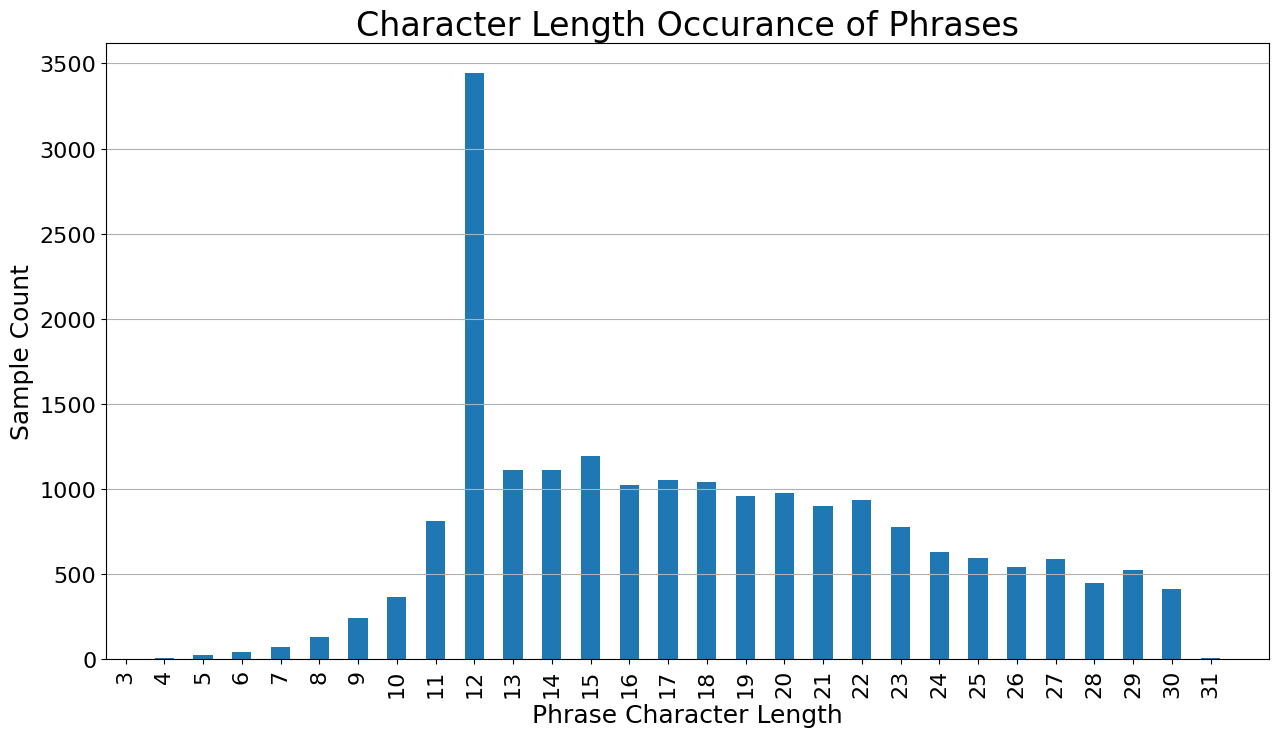

In [112]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
train['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train['phrase_char_len'].max() - 1.50)
plt.xlabel('Phrase Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

In [27]:
# Use Set to keep track of unique characters in phrases
UNIQUE_CHARACTERS = set()

for phrase in tqdm(train['phrase_char']):
    for c in phrase:
        UNIQUE_CHARACTERS.add(c)

# Sorted Unique Character
UNIQUE_CHARACTERS = np.array(sorted(UNIQUE_CHARACTERS))
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(UNIQUE_CHARACTERS)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

  0%|          | 0/19978 [00:00<?, ?it/s]

N_UNIQUE_CHARACTERS: 55


Example of Parquet File

In [28]:
# Read First Parquet File
example_parquet_df = pd.read_parquet(train['file_path'].iloc[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1784552841,0,0.492320,0.482797,0.485312,0.471907,0.481505,0.480572,0.478806,0.412168,0.475747,...,-0.096554,-0.104598,-0.074198,-0.107076,-0.111353,-0.108775,-0.090110,-0.112195,-0.111315,-0.107600
1784552841,1,0.492477,0.481592,0.483950,0.470245,0.480239,0.479128,0.476890,0.411729,0.473802,...,-0.052660,-0.054204,-0.052768,-0.063956,-0.054388,-0.046519,-0.065723,-0.066215,-0.052121,-0.041132
1784552841,2,0.487783,0.477862,0.480728,0.466654,0.476475,0.475539,0.474092,0.411478,0.471471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784552841,3,0.486822,0.476097,0.479721,0.463738,0.474360,0.473089,0.470957,0.402131,0.467684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784552841,4,0.489659,0.476537,0.479497,0.465263,0.475073,0.474147,0.472896,0.403360,0.470319,...,-0.082660,-0.086587,-0.062344,-0.071868,-0.059002,-0.048205,-0.066833,-0.069023,-0.053550,-0.040014


In [29]:
# Number of parquet chunks to analyse
N = 5
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/5 [00:00<?, ?it/s]

,Value
count,4996
mean,159
std,83
min,1
1%,6
5%,33
10%,66
25%,104
50%,149
75%,206


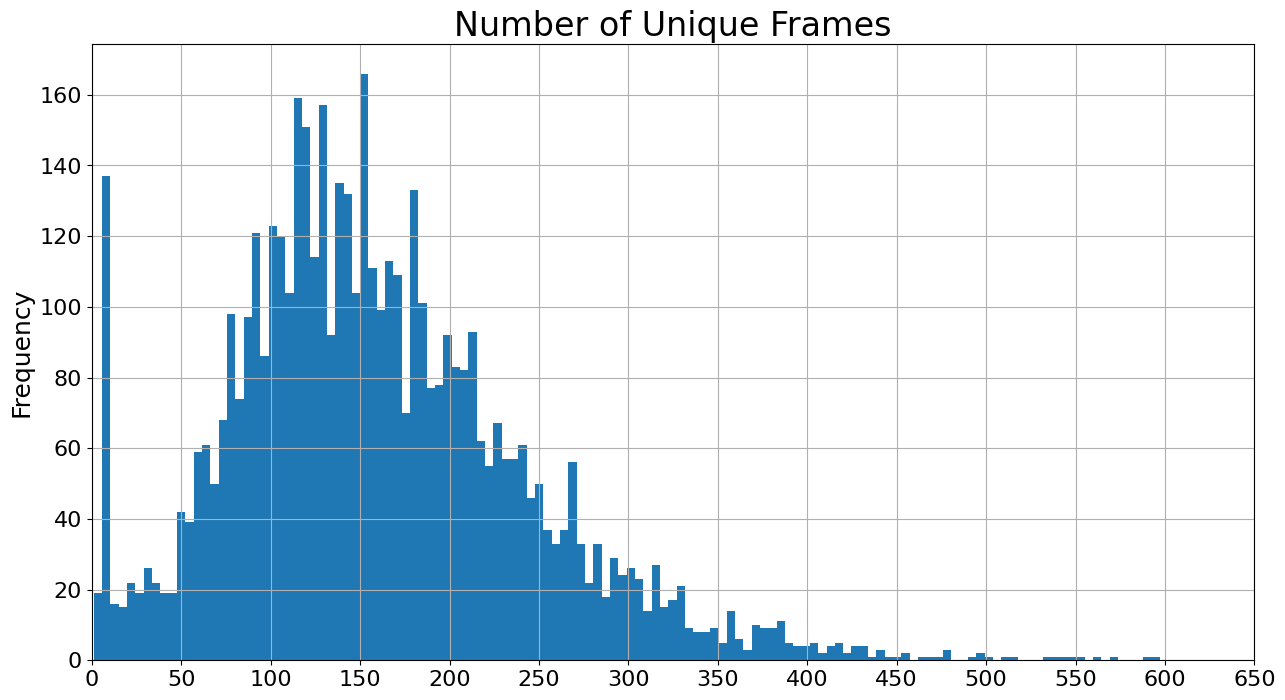

In [30]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('Value').astype(int))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()

  0%|          | 0/401 [00:00<?, ?it/s]

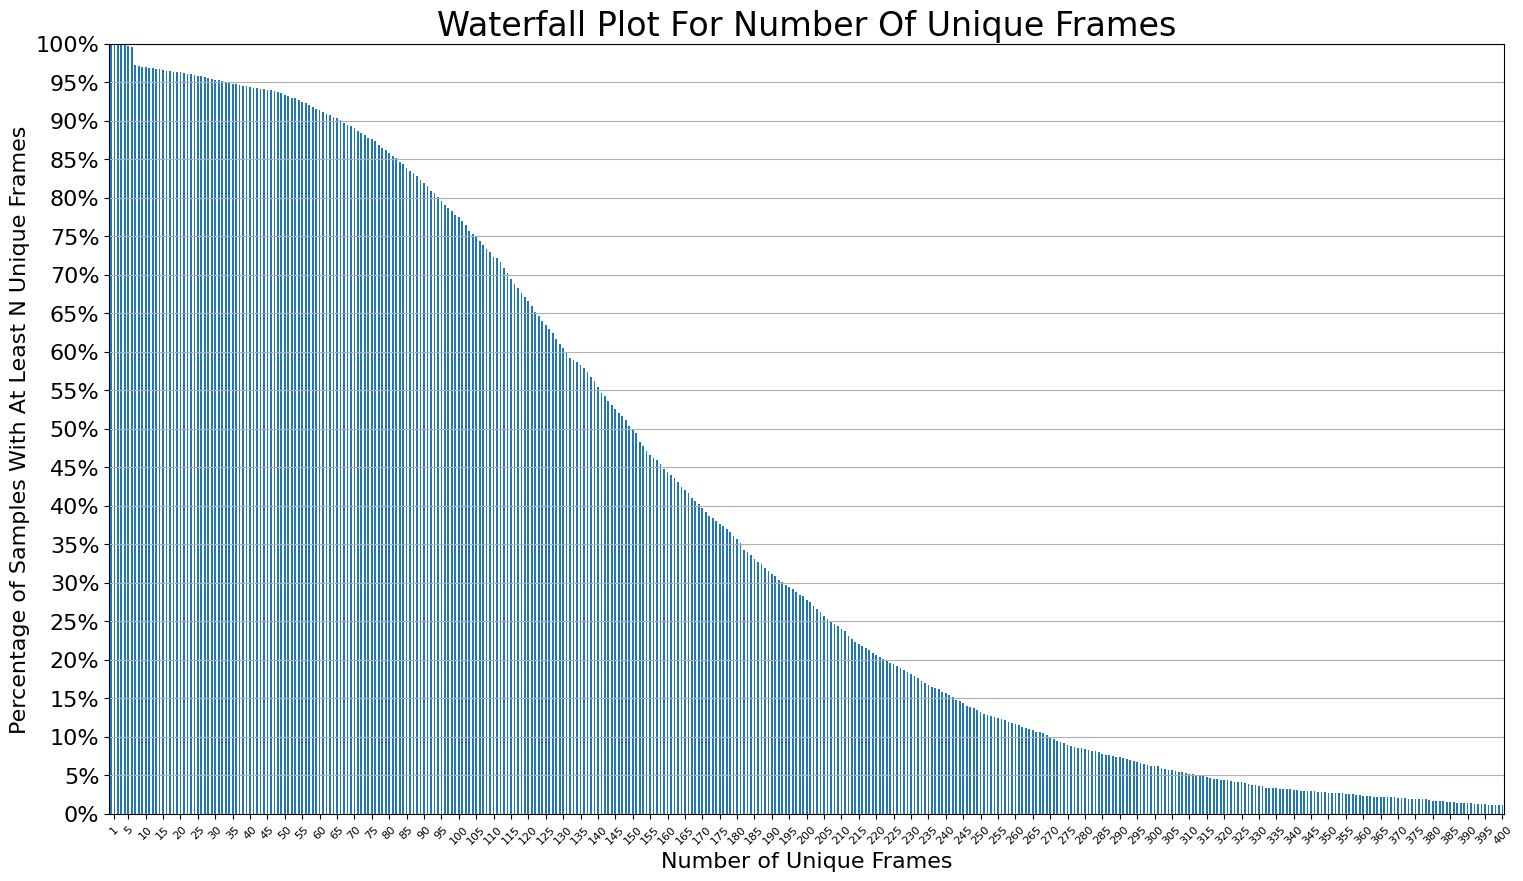

In [31]:
# With N_TARGET_FRAMES = 256 ~85% will be below
N_UNIQUE_FRAMES_WATERFALL = []
# Maximum Number of Unique Frames to use
N_MAX_UNIQUE_FRAMES = 400
# Compute Percentage
for n in tqdm(range(0,N_MAX_UNIQUE_FRAMES+1)):
    N_UNIQUE_FRAMES_WATERFALL.append(sum(N_UNIQUE_FRAMES >= n) / len(N_UNIQUE_FRAMES) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Unique Frames')
pd.Series(N_UNIQUE_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks([1] + np.arange(5, N_MAX_UNIQUE_FRAMES+5, 5).tolist(), size=8, rotation=45)
plt.xlabel('Number of Unique Frames', size=16)
plt.yticks(np.arange(0, 100+5, 5), [f'{i}%' for i in range(0,100+5,5)])
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Unique Frames', size=16)
plt.show()

Landmark Indices

In [32]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue

            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [33]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [34]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [35]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

Frames with no values

In [36]:
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)

        # Hacky
        data = data[None]

        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])

        return data

preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [37]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
# Number of parquet chunks to analyse
N = len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

  0%|          | 0/20 [00:00<?, ?it/s]

,# Frames
count,19978
mean,93
std,73
min,1
1%,1
5%,5
10%,11
25%,35
50%,81
75%,133


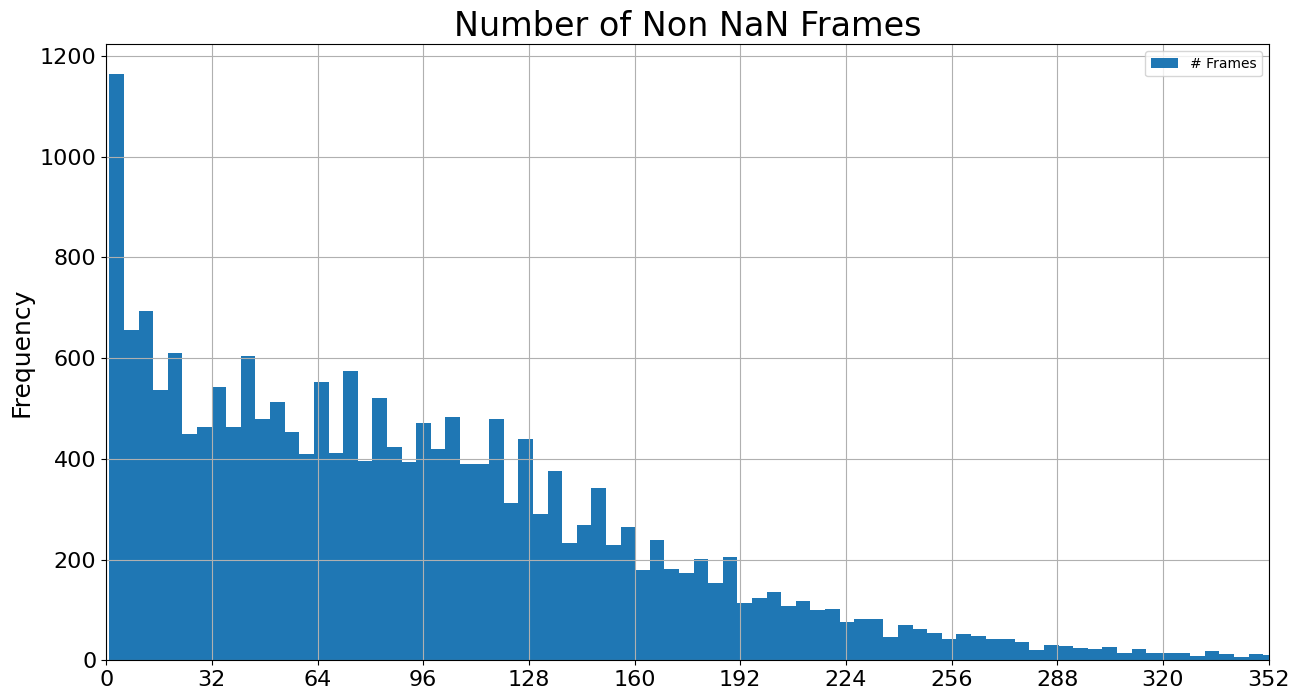

In [38]:
# Number of frames in each video with hand coordinates
display(N_NON_NAN_FRAMES.describe(percentiles=PERCENTILES).astype(int))

N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()

In [39]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)

        # Hacky
        data = data[None]

        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]

        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )

        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])

        return data

preprocess_layer = PreprocessLayer()

inputs = group_df[COLUMNS0].values
inputs = inputs[:1]

frames = preprocess_layer(inputs)

print(f'inputs shape: {inputs.shape}')
print(f'frames shape: {frames.shape}, NaN count: {np.isnan(frames).sum()}')

inputs shape: (1, 164)
frames shape: (128, 164), NaN count: 0


X/Y

In [40]:
# Target Arrays Processed Input Videos
X = np.zeros([N_SAMPLES, N_TARGET_FRAMES, N_COLS], dtype=np.float32)
# Ordinally Encoded Target With value 59 for pad token
y = np.full(shape=[N_SAMPLES, N_TARGET_FRAMES], fill_value=N_UNIQUE_CHARACTERS, dtype=np.int8)
# Phrase Type
y_phrase_type = np.empty(shape=[N_SAMPLES], dtype=object)

In [41]:
# All Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Numbre Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Progress Logging
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1]
    if idx < 10:
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1

        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        # Assign
        X[row] = frames
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            y[row, col] = CHAR2ORD.get(char)
        # Add EOS Token
        y[row, col+1] = EOS_TOKEN
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        # Row Count
        row += 1
    # clean up
    gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

Processed 00/20 parquet files
Processed 01/20 parquet files
Processed 02/20 parquet files
Processed 03/20 parquet files
Processed 04/20 parquet files
Processed 05/20 parquet files
Processed 06/20 parquet files
Processed 07/20 parquet files
Processed 08/20 parquet files
Processed 09/20 parquet files
Processed 10/20 parquet files
Processed 11/20 parquet files
Processed 12/20 parquet files
Processed 13/20 parquet files
Processed 14/20 parquet files
Processed 15/20 parquet files
Processed 16/20 parquet files
Processed 17/20 parquet files
Processed 18/20 parquet files
Processed 19/20 parquet files


In [42]:
# rows denotes the number of samples with frames/character above threshold
print(f'row: {row}, count: {count}')

row: 18415, count: 19978


In [43]:
# Example target, note the phrase is padded with the pad token 59
print(f'Example Target: {y[0]}')

Example Target: [39 51 51 47 50 25 14 14 54 54 54 13 55 45 12 12 47 36 32 49 46 43 12 55
 54 32 13 46 49 38 61 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55
 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55
 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55
 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55
 55 55 55 55 55 55 55 55]


In [44]:
# Filer X/y
X = X[:row]
y = y[:row]

In [45]:
# Save X/y
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 16621, # Val Samples: 1794


In [46]:
# Save X/y
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 16621, # Val Samples: 1794


,Value
count,19978.00
mean,9.02
std,3.83
min,0.04
1%,0.33
5%,2.42
10%,4.59
25%,6.77
50%,8.87
75%,11.21


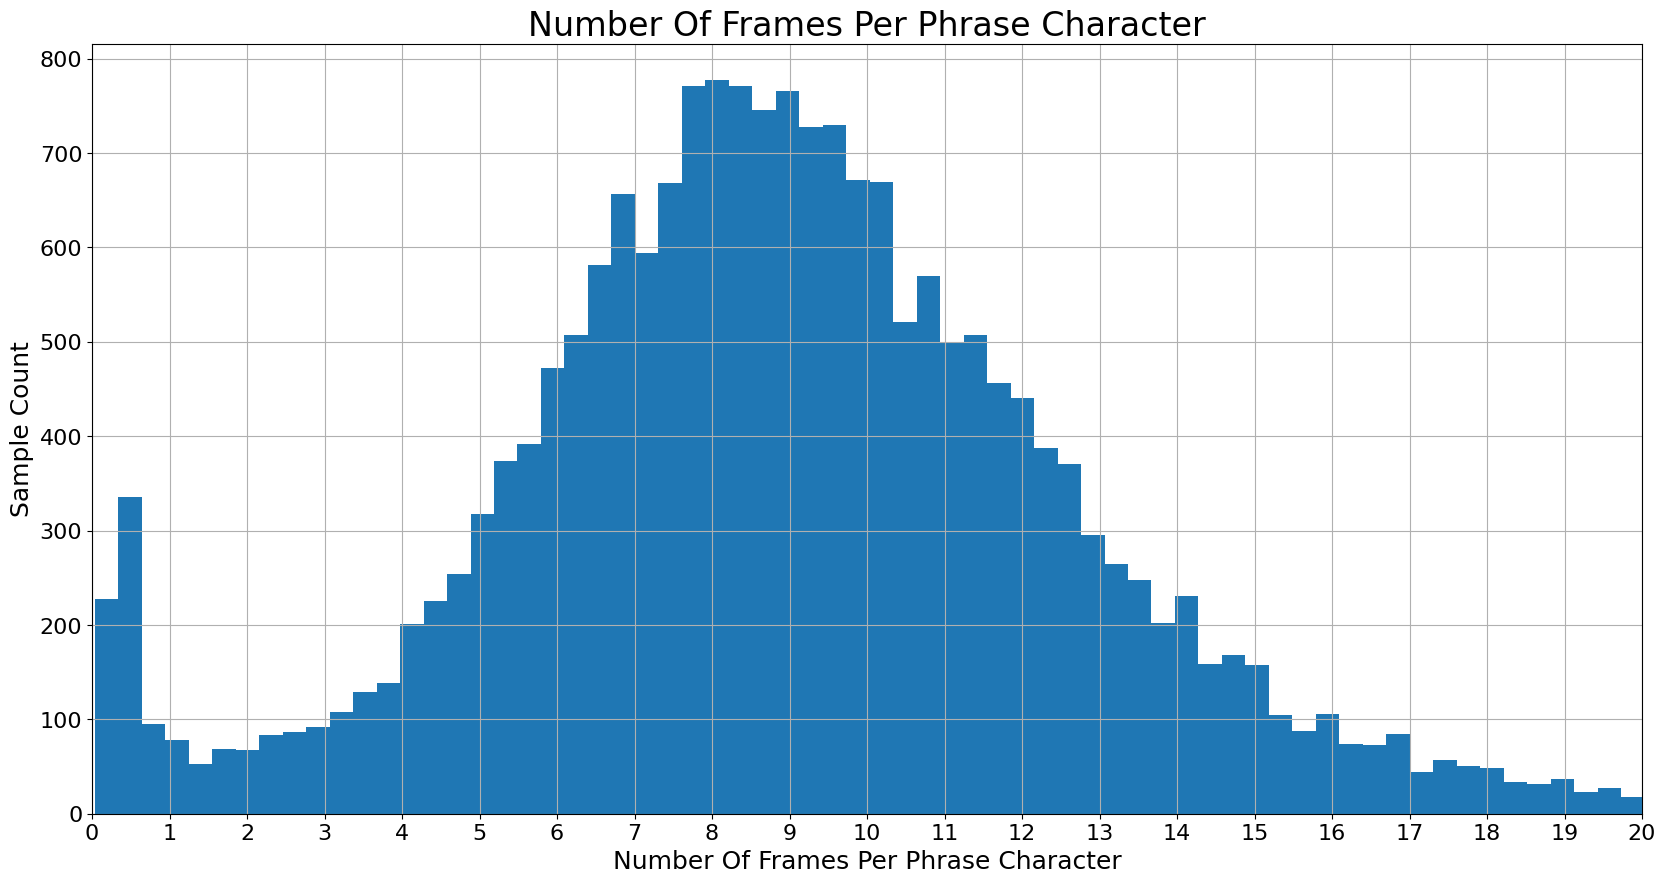

In [47]:
N_FRAMES_PER_CHARACTER_S = pd.Series(N_FRAMES_PER_CHARACTER)

display(N_FRAMES_PER_CHARACTER_S.describe(percentiles=PERCENTILES).to_frame('Value').round(2))

plt.figure(figsize=(20,10))
plt.title('Number Of Frames Per Phrase Character')
N_FRAMES_PER_CHARACTER_S.plot(kind='hist', bins=128)
# Plot till 99th percentile
p99 = math.ceil(np.percentile(N_FRAMES_PER_CHARACTER_S, 99))
plt.xticks(np.arange(0, p99+1, 1))
plt.xlim(0, p99)
plt.xlabel('Number Of Frames Per Phrase Character')
plt.ylabel('Sample Count')
plt.grid()
plt.show()

  0%|          | 0/164 [00:00<?, ?it/s]

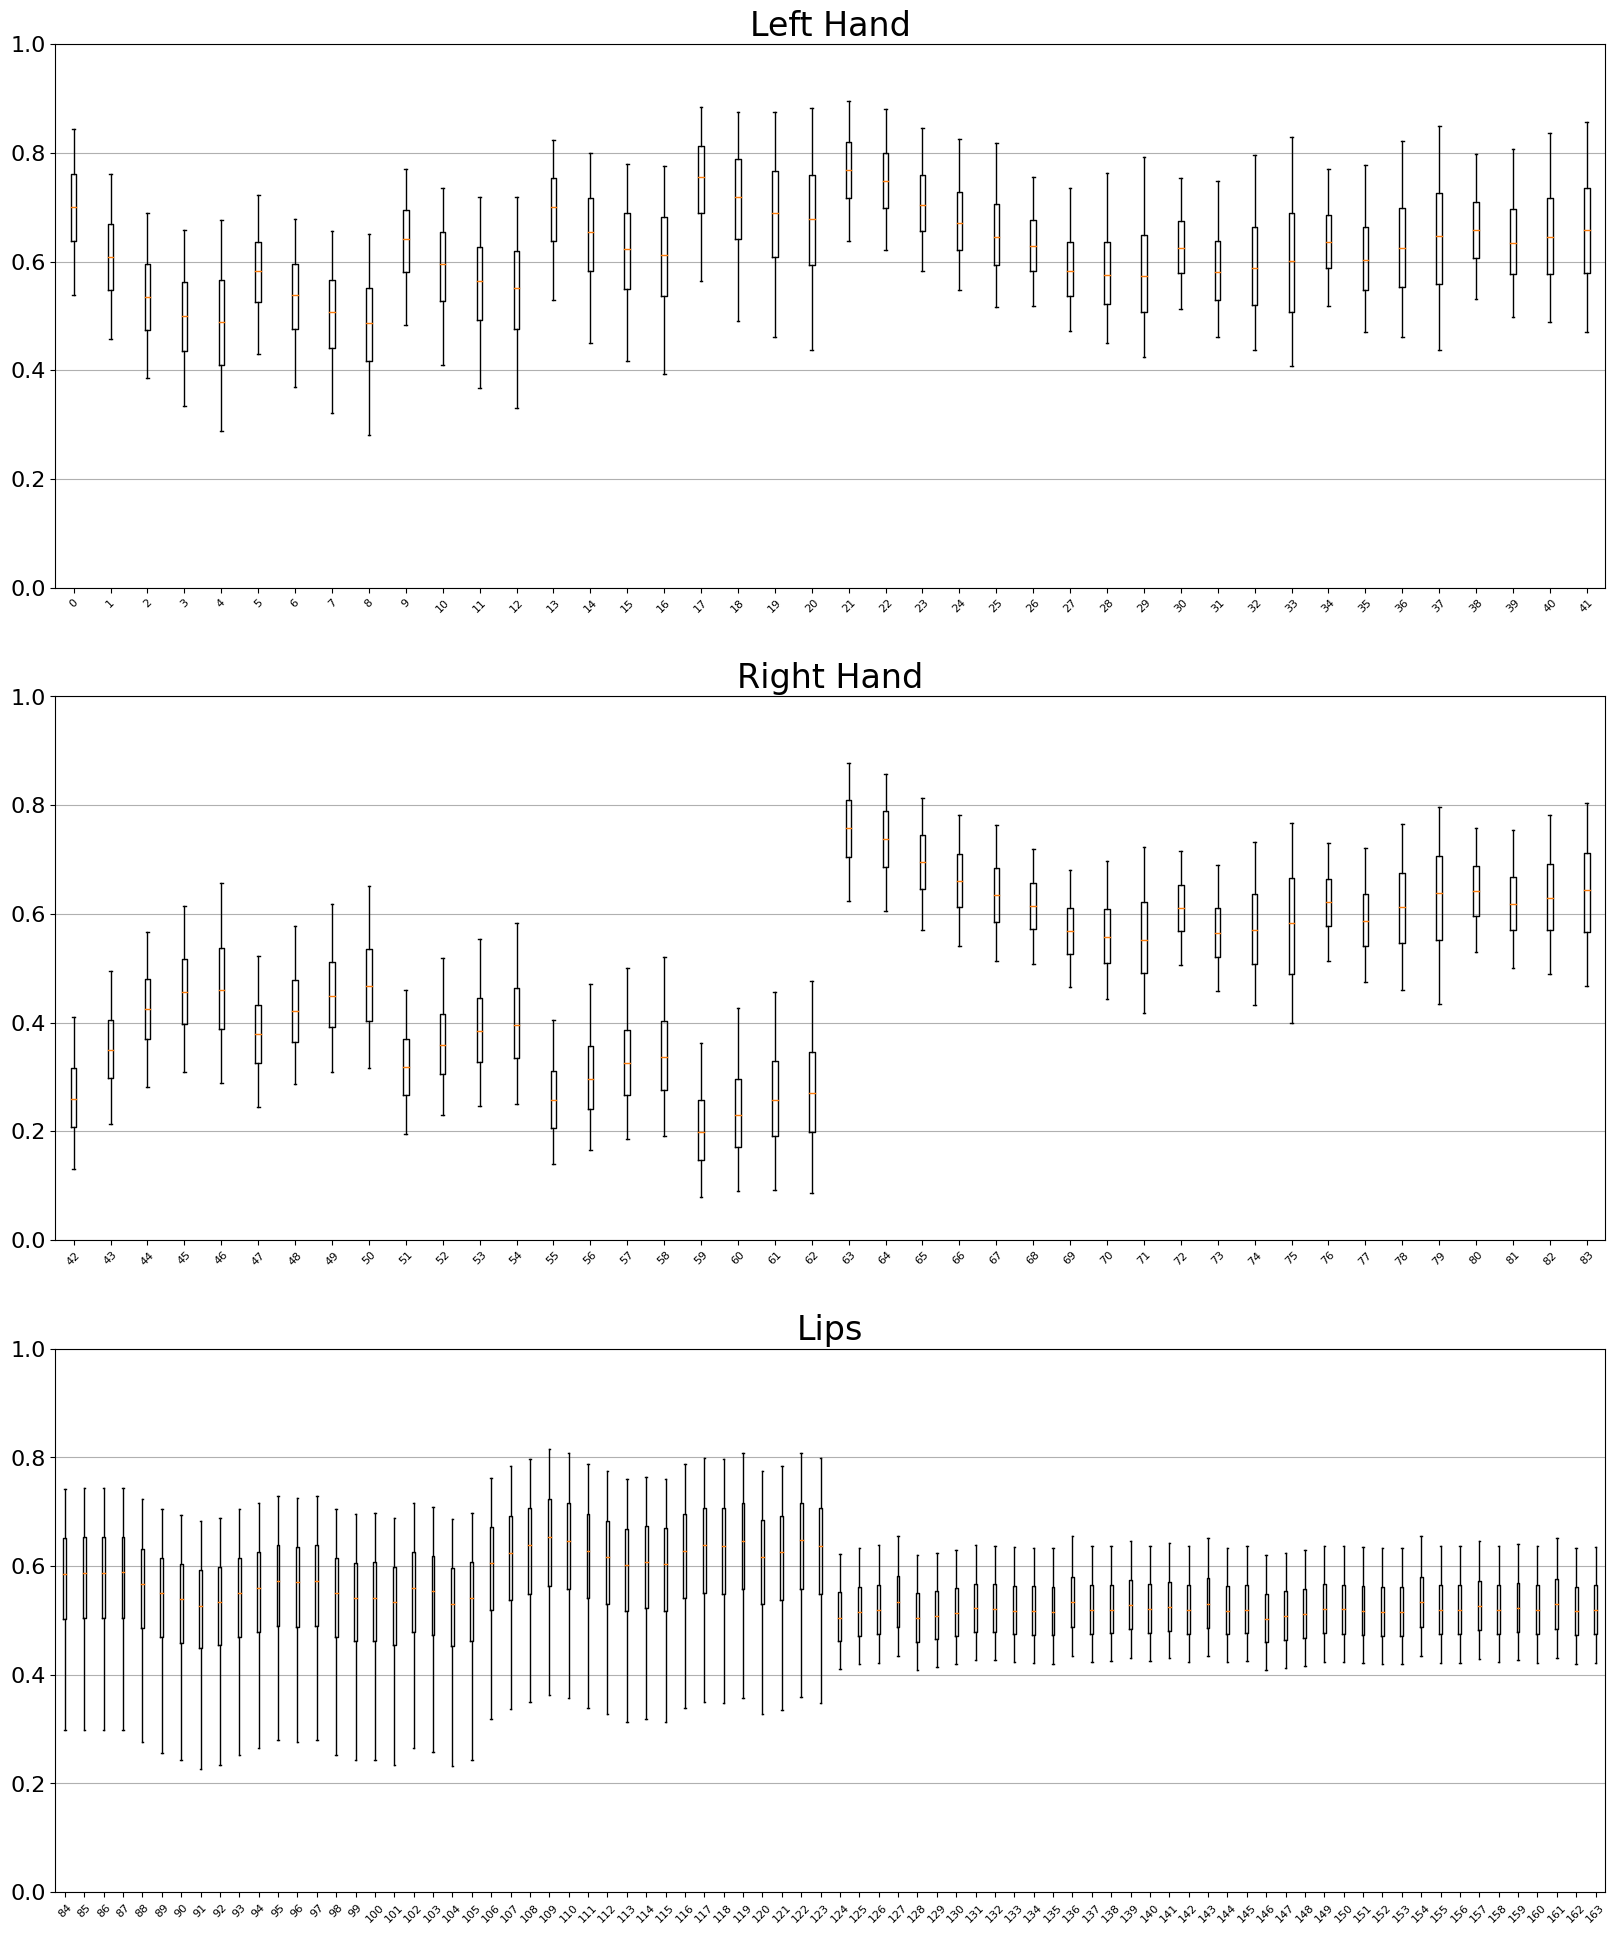

In [48]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)

    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))

    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()

    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)

In [56]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/root/ASL_data/train_landmarks/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 20 Inference Pickle Files


In [55]:
INFERENCE_FILE_PATHS

Series([], dtype: float64)

Load X/y

In [52]:
# Train/Validation
if USE_VAL:
    # TRAIN
    X_train = np.load('/content/X_train.npy')
    y_train = np.load('/content/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load('/content/X_val.npy')
    y_val = np.load('/content/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# Train On All Data
else:
    # TRAIN
    X_train = np.load('/content/X.npy')
    y_train = np.load('/content/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')

X_train shape: (18415, 128, 164)


Example Batch

In [53]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

In [111]:
len(X_batch['phrase'][0])

31

Example of Parquet

In [58]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1784552841,0,0.492320,0.482797,0.485312,0.471907,0.481505,0.480572,0.478806,0.412168,0.475747,...,-0.096554,-0.104598,-0.074198,-0.107076,-0.111353,-0.108775,-0.090110,-0.112195,-0.111315,-0.107600
1784552841,1,0.492477,0.481592,0.483950,0.470245,0.480239,0.479128,0.476890,0.411729,0.473802,...,-0.052660,-0.054204,-0.052768,-0.063956,-0.054388,-0.046519,-0.065723,-0.066215,-0.052121,-0.041132
1784552841,2,0.487783,0.477862,0.480728,0.466654,0.476475,0.475539,0.474092,0.411478,0.471471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784552841,3,0.486822,0.476097,0.479721,0.463738,0.474360,0.473089,0.470957,0.402131,0.467684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784552841,4,0.489659,0.476537,0.479497,0.465263,0.475073,0.474147,0.472896,0.403360,0.470319,...,-0.082660,-0.086587,-0.062344,-0.071868,-0.059002,-0.048205,-0.066833,-0.069023,-0.053550,-0.040014


In [114]:
len(example_parquet_df.iloc[0])

1630

Landmark Indices

In [59]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue

            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [60]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [61]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [62]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

In [64]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/content/MEANS.npy').reshape(-1)
STDS = np.load('/content/STDS.npy').reshape(-1)

TF Preprocessing Layer

In [65]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)

        # Hacky
        data = data[None]

        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]

        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )

        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])

        return data

preprocess_layer = PreprocessLayer()

In [68]:
# Function To Test Preprocessing Layer
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')

    return data

Train Dataset

In [69]:
# Train Dataset Iterator
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)

        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]

        yield inputs, outputs

In [70]:
train_dataset = get_train_dataset(X_train, y_train)

In [71]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 288


Validation Dataset

In [72]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [73]:
# Validation Dataset
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

In [74]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

Model Config

In [75]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 4
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

Landmark Embedding

In [76]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

Embedding

In [77]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True

    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding

        return x

Transformer

In [78]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True

    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])

    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

Encoder

In [79]:
# https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
# Encoder based on multiple transformer blocks
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.supports_masking = True

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_ENCODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_ENCODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_ENCODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            # Optional Projection to Decoder Dimension
            if UNITS_ENCODER != UNITS_DECODER:
                self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False

    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask

    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, x, x, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))

        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)

        return x

Decoder

In [80]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True

    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))

    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask

    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask

    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])

        return x

In [81]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

Non Pad/SOS/EOS Token Accuracy

In [82]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()

    def reset_state(self):
        self.top_k_acc.reset_state()

Loss Weigths

In [84]:
N_UNIQUE_CHARACTERS

55

In [87]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)
# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN] = 0

Label smoothing and Sparse Categorical Crossentropy

In [88]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

Model

In [92]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp

    # Masking
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)

    # Embedding
    x = Embedding()(x)

    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)

    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, frames_inp)

    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
    ], name='classifier')(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)

    # Categorical Crossentropy Loss With Label Smoothing
    loss = scce_with_ls

    # Adam Optimizer
    optimizer = tf.keras.optimizers.Adam()

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )

    return model

In [90]:
# Input data
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 31)


In [93]:
tf.keras.backend.clear_session()

model = get_model()

In [95]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames (InputLayer)         [(None, 128, 164)]           0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 164)             0         ['frames[0][0]']              
                                                                                                  
 embedding (Embedding)       (None, 128, 384)             259968    ['masking[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (  multiple                     210816    []                           |
| LandmarkEmbedding)                                                                          

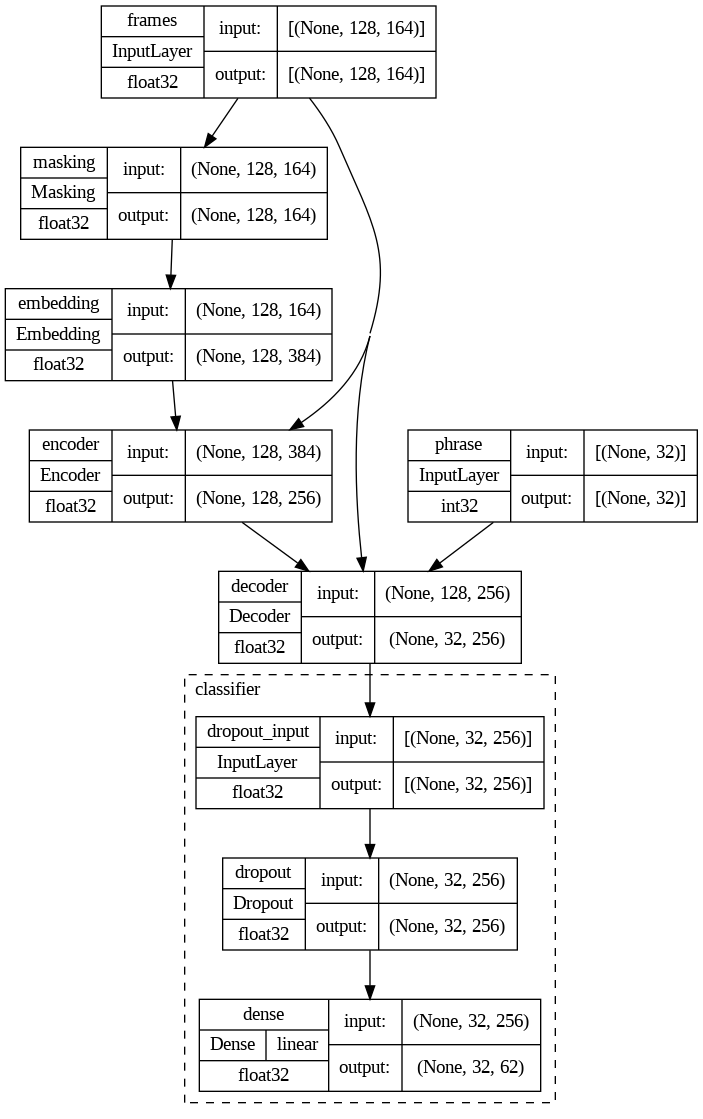

In [96]:
# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

Verify Training Flag

In [97]:
def verify_correct_training_flag():
    # Verify static output for inference
    pred = model(X_batch_small, training=False)
    for _ in tqdm(range(10)):
        assert tf.reduce_min(tf.cast(pred == model(X_batch_small, training=False), tf.int8)) == 1

    # Verify at least 99% varying output due to dropout during training
    for _ in tqdm(range(10)):
        assert tf.reduce_mean(tf.cast(pred != model(X_batch_small, training=True), tf.float32)) > 0.99

verify_correct_training_flag()

ValueError: Input 1 of layer "model" is incompatible with the layer: expected shape=(None, 32), found shape=(32, 31)

Verify No NaN Predictions

In [110]:
# Verify No NaN predictions
def verify_no_nan_predictions():
    y_pred = model.predict(
        val_dataset if USE_VAL else train_dataset,
        steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else 100,
        verbose=VERBOSE,
    )

    print(f'# NaN Values In Predictions: {np.isnan(y_pred).sum()}')

    plt.figure(figsize=(15,8))
    plt.title(f'Logit Predictions Initialized Model')
    pd.Series(y_pred.flatten()).plot(kind='hist', bins=128)
    plt.xlabel('Logits')
    plt.grid()
    plt.show()

verify_no_nan_predictions()

InvalidArgumentError: Graph execution error:

Detected at node model/decoder/add defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-110-74b707b5ae77>", line 18, in <cell line: 18>

  File "<ipython-input-110-74b707b5ae77>", line 3, in verify_no_nan_predictions

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "<ipython-input-80-be8465f44d27>", line 73, in call

required broadcastable shapes
	 [[{{node model/decoder/add}}]] [Op:__inference_predict_function_87075]

Learning Rate Scheduler

In [ ]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [ ]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

Weight Decay Callback

In [ ]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

Evaluate Initialized Model

In [ ]:
# Evaluate Initialized Model On Validation Data
y_pred = model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    verbose=VERBOSE,
)

Baseline

In [ ]:
# baseline accuracy when only pad token is predicted
if USE_VAL:
    baseline_accuracy = np.mean(y_val == PAD_TOKEN)
else:
    baseline_accuracy = np.mean(y_train == PAD_TOKEN)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Train

In [ ]:
gc.collect()

In [ ]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            validation_data=val_dataset if USE_VAL else None,
            validation_steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else None,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose=VERBOSE,
        )

In [ ]:
# Load Weights
if LOAD_WEIGHTS:
    model.load_weights('/kaggle/input/aslfr-training-python37/model.h5')
    print(f'Successfully Loaded Pretrained Weights')

In [ ]:
# Save Model Weights
model.save_weights('model.h5')

In [ ]:
# Verify Model is Loaded Correctly
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

Levenshtein Distance

In [ ]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)

    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

In [ ]:
@tf.function(jit_compile=True)
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)

    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH) < idx + 1,
            tf.argmax(outputs, axis=2, output_type=tf.int32),
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0)
    outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)

    # Return a dictionary with the output tensor
    return outputs

    # Return a dictionary with the output tensor
    return outputs

Levenshtein Distance Train

In [ ]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break

    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)

    return LD_TRAIN_DF

In [ ]:
LD_TRAIN_DF = get_ld_train()

# Display Errors
display(LD_TRAIN_DF.head(30))

In [ ]:
# Value Counts
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

# Evaluation Metric
N = LD_TRAIN_DF['phrase_true_len'].sum()
D = LD_TRAIN_DF['levenshtein_distance'].sum()
nld = (N - D) / N

LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

plt.figure(figsize=(15,8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.levenshtein_distance.max()+0.50)
plt.grid(axis='y')
plt.savefig('temp.png')
plt.show()

Levenstein Distance Evaluation

In [ ]:
# Compute Levenstein Distances
def get_ld_val():
    N = 100 if IS_INTERACTIVE else 1000
    LD_VAL = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val, total=N), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_VAL.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break

    # Convert to DataFrame
    LD_VAL_DF = pd.DataFrame(LD_VAL)

    return LD_VAL_DF

In [ ]:
if USE_VAL:
    LD_VAL_DF = get_ld_val()

    # Display Errors
    display(LD_VAL_DF.head(30))

In [ ]:
# Value Counts
if USE_VAL:
    # Evaluation Metric
    N = LD_VAL_DF['phrase_true_len'].sum()
    D = LD_VAL_DF['levenshtein_distance'].sum()
    nld = (N - D) / N

    LD_VAL_VC = dict([(i, 0) for i in range(LD_VAL_DF['levenshtein_distance'].max()+1)])
    for ld in LD_VAL_DF['levenshtein_distance']:
        LD_VAL_VC[ld] += 1

    plt.figure(figsize=(15,8))
    pd.Series(LD_VAL_VC).plot(kind='bar', width=1)
    plt.title(f'Validation Levenstein Distance Distribution | Mean: {LD_VAL_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
    plt.xlabel('Levenstein Distance')
    plt.ylabel('Sample Count')
    plt.xlim(-0.50, LD_VAL_DF.levenshtein_distance.max()+0.50)
    plt.grid(axis='y')
    plt.savefig('temp.png')
    plt.show()

Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    # Only plot when training
    if not TRAIN_MODEL:
        return

    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [ ]:
plot_history_metric('loss', f_best=np.argmin)

In [ ]:
plot_history_metric('top1acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
plot_history_metric('top5acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

Inference

In [ ]:
# Model Layer Names
for l in model.layers:
    print(l.name)

In [ ]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model

    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)

        return x

    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('classifier')(x)

        return x

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN

        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)

        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

In [ ]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)